# Genetic Programming

In [1]:
!pip3 install --config-settings="--global-option=build_ext" --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" pygraphviz

**Context**

This walkthrough will demonstrate genetic programming (GP) in DEAP. To do that we will address the 'odd parity' problem.

Parity is one of the classical GP problems. The input is an array of Boolean values. The solution should output a 'parity bit' of 1 if there are an even number of values, and a 0 otherwise. Usually 6 Boolean inputs are used (Parity-6), and the goal is to match the good parity bit value for each of the possible entries.



In [2]:
import operator
import random
import pygraphviz as pgv
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Training data generation

First we initialize the parity problem input and output (target) matrices

In [3]:
PARITY_FANIN_M = 6
PARITY_SIZE_M = 2**PARITY_FANIN_M

inputs = [None] * PARITY_SIZE_M
outputs = [None] * PARITY_SIZE_M

In [4]:
for i in range(PARITY_SIZE_M):
    inputs[i] = [None] * PARITY_FANIN_M
    value = i
    dividor = PARITY_SIZE_M
    parity = 1
    for j in range(PARITY_FANIN_M):
        dividor /= 2
        if value >= dividor:
            inputs[i][j] = 1
            parity = int(not parity)
            value -= dividor
        else:
            inputs[i][j] = 0
    outputs[i] = parity

Let's have a look at the training data that have been generated

In [5]:
len(inputs)

64

In [6]:
for i, o in zip(inputs,outputs):
    print(i,o)

[0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 1] 0
[0, 0, 0, 0, 1, 0] 0
[0, 0, 0, 0, 1, 1] 1
[0, 0, 0, 1, 0, 0] 0
[0, 0, 0, 1, 0, 1] 1
[0, 0, 0, 1, 1, 0] 1
[0, 0, 0, 1, 1, 1] 0
[0, 0, 1, 0, 0, 0] 0
[0, 0, 1, 0, 0, 1] 1
[0, 0, 1, 0, 1, 0] 1
[0, 0, 1, 0, 1, 1] 0
[0, 0, 1, 1, 0, 0] 1
[0, 0, 1, 1, 0, 1] 0
[0, 0, 1, 1, 1, 0] 0
[0, 0, 1, 1, 1, 1] 1
[0, 1, 0, 0, 0, 0] 0
[0, 1, 0, 0, 0, 1] 1
[0, 1, 0, 0, 1, 0] 1
[0, 1, 0, 0, 1, 1] 0
[0, 1, 0, 1, 0, 0] 1
[0, 1, 0, 1, 0, 1] 0
[0, 1, 0, 1, 1, 0] 0
[0, 1, 0, 1, 1, 1] 1
[0, 1, 1, 0, 0, 0] 1
[0, 1, 1, 0, 0, 1] 0
[0, 1, 1, 0, 1, 0] 0
[0, 1, 1, 0, 1, 1] 1
[0, 1, 1, 1, 0, 0] 0
[0, 1, 1, 1, 0, 1] 1
[0, 1, 1, 1, 1, 0] 1
[0, 1, 1, 1, 1, 1] 0
[1, 0, 0, 0, 0, 0] 0
[1, 0, 0, 0, 0, 1] 1
[1, 0, 0, 0, 1, 0] 1
[1, 0, 0, 0, 1, 1] 0
[1, 0, 0, 1, 0, 0] 1
[1, 0, 0, 1, 0, 1] 0
[1, 0, 0, 1, 1, 0] 0
[1, 0, 0, 1, 1, 1] 1
[1, 0, 1, 0, 0, 0] 1
[1, 0, 1, 0, 0, 1] 0
[1, 0, 1, 0, 1, 0] 0
[1, 0, 1, 0, 1, 1] 1
[1, 0, 1, 1, 0, 0] 0
[1, 0, 1, 1, 0, 1] 1
[1, 0, 1, 1, 1, 0] 1
[1, 0, 1, 1, 

# Setting up the algorithm

Our individual will be a function to which we will pass PARITY_FANIN_M values (here 6). As such, you need to define a primitive set that takes in that number of values. You would increase this if you wanted to pass more values, and have it at zero if your individual does not receive any arguments when it is executed.

In [7]:
#pset = gp.PrimitiveSet("MAIN", 0)
pset = gp.PrimitiveSet("MAIN", PARITY_FANIN_M, "IN")

By default input arguments are termed ARG0, ARG2 ... ARGi. We're fine with that here, but let's look at how to name the first argument ARG0 to x.

In [8]:
#pset.renameArguments(ARG0='x')

# Now let's add some functions

We now register our functions and terminals. We would normally not know the function in advance, and might want to start with a limited set and then expand if needed.

In [9]:
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.xor, 2)
pset.addPrimitive(operator.not_, 1)
pset.addTerminal(1)
pset.addTerminal(0)

It's possible to use other functions, such as math ones, but we're limited to logic functions here.

In [10]:
#pset.addPrimitive(operator.add, 2)
#pset.addPrimitive(operator.sub, 2)
#pset.addPrimitive(operator.mul, 2)
#pset.addPrimitive(protectedDiv, 2)
#pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(math.sin, 1)
#pset.addPrimitive(math.cos, 1)

You can also add an **ephemeral Constant**. The value of the constant is randomly initialised and then kept constant for a particular individual tree, but will differ from one Tree to another. Again, we do not need that here.

In [11]:
#pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

Note that we have used lambda to create an anonymous function on the fly. This is so that we can define the arguments to randint to constrain it between -1 and 1.

In [12]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

The only real decision that you need to make when defining populations in the toolbox is what type of initialization you want to use. Individuals will always be of type toolbox.expr.

In [13]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)

In [14]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [15]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

You might consider adding some limits on the height of any generated branch.

In [16]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

## Evaluation function

Provided below is the evaluation function that you should use.

In [17]:
def evalParity(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*in_) == out for in_, out in zip(inputs, outputs)),

In [18]:
toolbox.register("evaluate", evalParity)

## Register some stats

In [19]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

## Main algorithm

Before, you've always seen the full algorithm coded out. You can do the same here, but for brevity in this walkthrough I have used eaSimple.

In [20]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=150, stats=mstats,
                                   halloffame=hof, verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	500   	31.99	0  	36 	28 	500   	0.527162	18.896	0  	62 	4  	500   	12.2367
1  	281   	32.06	1  	36 	28 	281   	0.494368	18.432	1  	59 	2  	281   	12.2174
2  	272   	32.178	2  	40 	28 	272   	0.840426	17.972	2  	59 	1  	272   	12.5433
3  	286   	32.33 	3  	36 	31 	286   	0.970103	18.262	3  	55 	1  	286   	13.5467
4  	287   	32.6  	4  	36 	28 	287   	1.32966 	19.38 	4  	55 	1  	287   	14.3503


5  	277   	33.214	5  	40 	28 	277   	1.70652 	24.48 	5  	56 	1  	277   	16.2062
6  	292   	34.216	6  	40 	30 	292   	1.8935  	31.44 	6  	55 	1  	292   	15.3131
7  	285   	35.114	7  	40 	24 	285   	1.93106 	34.606	7  	55 	1  	285   	13.0454
8  	259   	35.782	8  	40 	24 	259   	1.96022 	33.678	8  	55 	1  	259   	12.4281
9  	261   	36.24 	9  	40 	24 	261   	2.61197 	31.538	9  	55 	7  	261   	12.9688
10 	270   	36.968	10 	40 	24 	270   	3.04483 	29.026	10 	59 	8  	270   	13.9039
11 	267   	37.648	11 	40 	24 	267   	3.21062 	27.826	11 	55 	1  	267   	14.8611
12 	272   	38.016	12 	40 	24 	272   	3.34421 	27.52 	12 	60 	1  	272   	15.7982
13 	258   	38.188	13 	48 	24 	258   	3.35211 	27.86 	13 	61 	1  	258   	15.8501
14 	268   	38.116	14 	48 	16 	268   	3.65876 	29.382	14 	59 	3  	268   	16.651 
15 	296   	37.9  	15 	48 	16 	296   	3.99775 	30.272	15 	57 	3  	296   	17.0232
16 	282   	38.668	16 	48 	24 	282   	3.73869 	31.484	16 	59 	1  	282   	17.645 
17 	287   	38.9  	17 	48 	24 	287   	4.2

## Basic plots

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = log.chapters['fitness'].select("gen")
_min = log.chapters['fitness'].select("min")
_max = log.chapters['fitness'].select("max")
avgs = log.chapters['fitness'].select("avg")
stds = log.chapters['fitness'].select("std")

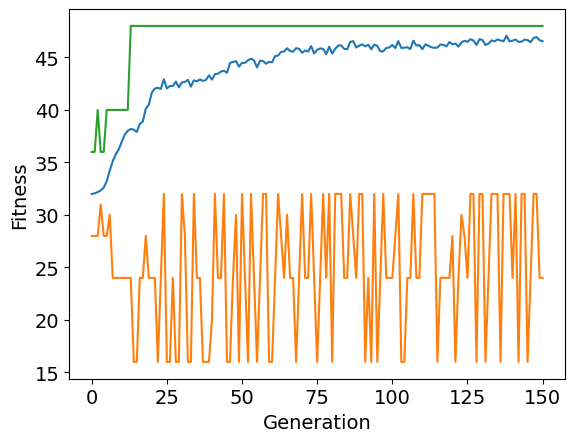

In [22]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

Sometimes you might not be able to show the min and max on the same figure because of the scales.

Question: Why do you think the minimum is always so low?

## Let's examine our best individual

In [23]:
indv = tools.selBest(pop, 1)[0]
print(indv)

and_(xor(or_(IN2, and_(xor(IN2, or_(xor(IN4, IN4), not_(IN2))), or_(0, IN2))), or_(and_(xor(IN0, IN2), not_(1)), IN5)), xor(IN4, xor(IN3, xor(IN1, IN0))))


In [24]:
nodes, edges, labels = gp.graph(indv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

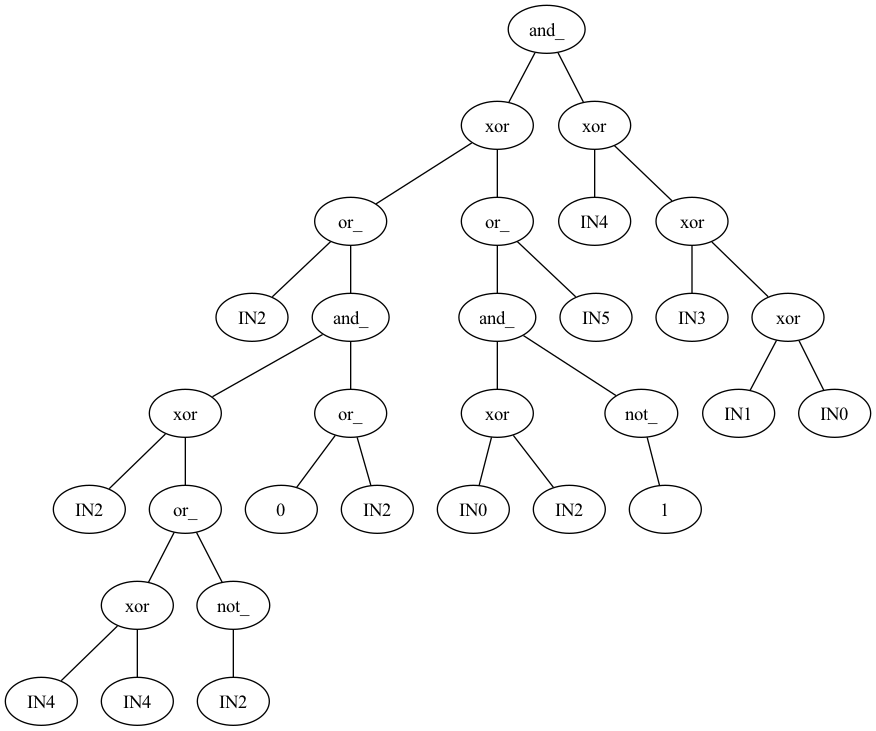

In [25]:
from IPython.display import Image

treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

In [26]:
toolbox.evaluate(indv)

(48,)